Contents __TODO: remove when done (only for development purpose)__

+ [Prediction algorithms used in this lecture](#prediction)
+ [Incomplete / missing data](#missing-data)
+ [Incorrect data](#incorrect-data)
+ [Biased data](#biased-data)
+ [More ideas](#more-ideas)

In [1]:
# Cell to hide - just an option

import pandas as pd
pd.set_option('display.max_columns', 27)

In this section, we want to try out a few experiments with the 2 datasets we have. You will perform some simple prediction tasks from the data, predicting for example the length of a ship, or its future trajectory.

For now, you should only focus on the prediction task, using the raw data as you received them.

## Prediction algorithms used in this lecture <a class="anchor" id="prediction"></a>

__TODO: probably move this part and the corresponding functions to either the intro or the appendix. I think it's better if the students can use just knn_regression or rf_trajectory without caring too much about what's going on in there.__

This lecture is about data quality, so we do not want to focus too much on the task of prediction, but more on the data themselves. For this reason, the prediction functions have been simplified as much as possible, and we will use some simple algorithms from some Python libraries.

To understand how a simple task of supervised learning is led, refer to the introductory part (link) __TODO: link to the introduction about supervised learning__.

We will now quickly go through the prediction task.

There are 2 kinds of supervised prediction tasks: classification and regression. Here, they will be tackled the same way, only the algorithm used and the way of measuring the performance change. We will explore together the regression 

In [2]:
# KNN regression
def knn_regression(df, x,  y):
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsRegressor
    
    x_train, x_test, y_train, y_test = train_test_split(df[x], df[y], test_size = 0.2, random_state = 0)
    
    x_train = x_train.fillna(value = 0)
    x_test = x_test.fillna(value = 0)
    y_train = y_train.fillna(value = 0)
    y_test = y_test.fillna(value = 0)
    
    knn = KNeighborsRegressor(n_neighbors = 25)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    
    return predictions, y_test

In [3]:
# KNN classification
def knn_classification(df, x,  y):
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier
    
    x_train, x_test, y_train, y_test = train_test_split(df[x], df[y], test_size = 0.2, random_state = 0)
    
    #x_train = x_train.fillna(value = 0)
    #x_test = x_test.fillna(value = 0)
    #y_train = y_train.fillna(value = 0)
    #y_test = y_test.fillna(value = 0)
    
    knn = KNeighborsClassifier(n_neighbors = 25)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    
    return predictions, y_test

In [4]:
def rf_trajectory(df, split, clas):
    '''
    Do time series prediction on df
    in:
    df: pandas DataFrame
    split: integer, between 0 and 1, percentage of train/test split
    clas: string, the name of the attribute to predict (do it separatly for latitude and longitude)
    '''
    import numpy as np
    from sklearn.metrics import mean_absolute_error
    from sklearn.ensemble import RandomForestRegressor
    
    # First, we create a new dataset with 2 additional columns for prediction:
    # - previous_clas: contains the value of the class attribute of the previous row (example: previous latitude value)
    # - diff_clas: the difference between the previous value and the current value for the class attribute
    
    df2 = pd.DataFrame(columns = ['TripID', 'BaseDateTime', clas, 'previous_clas', 'diff_clas'])
    
    df2['TripID'] = df['TripID']
    df2['BaseDateTime'] = df['BaseDateTime']
    df2[clas] = df[clas]
    
    previous_tripid = 'first'
    
    for index, row in df2.sort_values(['TripID', 'BaseDateTime']).iterrows():
        if previous_tripid != row['TripID']: # new trip
            previous_tripid = row['TripID']
            previous_clas = row[clas]
        
        df2.loc[index, 'previous_clas'] = previous_clas
        previous_clas = row[clas]
        
    df2['diff_clas'] = df2[clas] - df2['previous_clas']
    
    df2['previous_clas'] = pd.to_numeric(df2['previous_clas'])
    df2['diff_clas'] = pd.to_numeric(df2['diff_clas'])
    
    # Split training and testing sets: the training set is the first part of the data in the chronological order
    nb_train = int(split * len(df2))
    nb_test = int(len(df2) - nb_train)
    train = df2.head(nb_train)
    test = df2.tail(nb_test)
    
    # Baseline prediction: always predicts the last position
    baseline = mean_absolute_error(test[clas], test['previous_clas'])
    #print('Baseline: mean absolute error = %.5f' % baseline)
    
    # Random Forest prediction
    # Drop the timestamp columns because they cannot be processed by the random forest algorithm
    x_train, x_test = train.drop(columns = [clas, 'BaseDateTime'], axis = 1), test.drop(columns = [clas, 'BaseDateTime'], axis = 1)
    y_train, y_test = train[clas].values, test[clas].values

    rf = RandomForestRegressor(n_estimators = 1000, n_jobs = -1, random_state = 0)
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    error = mean_absolute_error(predictions, y_test)
    
    #print('Random Forest: mean absolute error = %.5f' % error)
    
    return train, test, predictions, baseline, error

## Incomplete / missing data <a class="anchor" id="missing-data"></a>

### 1
Exercise of prediction with and without NaN:
+ once it gives better results, example for prediction of Width from Length > because 0 Length might lower the mean value. Compare length and width values, plot graphs, compare NaN in both columns
+ once it gives worse results, identify why (because more NaN than non-NaN so prediction error is calculated on an easy problem (0 > 0)). Example, predict MeanSOG from DepLat, ArrLat, DepLon, ArrLon or from VesselType

In [5]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

In [6]:
# Prediction of Width from Length

from sklearn.metrics import mean_absolute_error

x = ['Length']
y = ['Width']

static_selected = static_data.dropna()

pred1, ytest1 = knn_regression(static_data, x, y)
pred2, ytest2 = knn_regression(static_selected, x, y)

print('MAE with all data: ' + str(mean_absolute_error(pred1, ytest1)))
print('MAE without NaN: ' + str(mean_absolute_error(pred2, ytest2)))

MAE with all data: 2.73451052631579
MAE without NaN: 2.0717238095238097


In [7]:
# Prediction of MeanSOG from start and end positions
x = ['DepLat', 'ArrLat', 'DepLon', 'ArrLon']
y = ['MeanSOG']

static_selected = static_data.dropna()

pred1, ytest1 = knn_regression(static_data, x, y)
pred2, ytest2 = knn_regression(static_selected, x, y)

print('MAE with all data: ' + str(mean_absolute_error(pred1, ytest1)))
print('MAE without NaN: ' + str(mean_absolute_error(pred2, ytest2)))

MAE with all data: 0.9136499460275772
MAE without NaN: 1.9541572056893803


In [8]:
# Prediction of MeanSOG from VesselType
x = ['VesselType']
y = ['MeanSOG']

static_selected = static_data.dropna()

pred1, ytest1 = knn_regression(static_data, x, y)
pred2, ytest2 = knn_regression(static_selected, x, y)

print('MAE with all data: ' + str(mean_absolute_error(pred1, ytest1)))
print('MAE without NaN: ' + str(mean_absolute_error(pred2, ytest2)))

MAE with all data: 0.9494952790387338
MAE without NaN: 3.0201554291315684


### 2
Exercise of trajectory prediction from one trip with and without gap of missing data

In [9]:
import pandas as pd

dynamic_data = pd.read_csv('./dynamic_data.csv')

In [10]:
# Choose the trip to do the prediction on, and do the prediction twice: for latitude and longitude separately

tripid = 221

df = dynamic_data.loc[dynamic_data['TripID'] == tripid].sort_values('BaseDateTime')
train_lat, test_lat, prediction_lat, baseline_lat, error_lat = rf_trajectory(df, 0.75, 'LAT')
train_lon, test_lon, prediction_lon, baseline_lon, error_lon = rf_trajectory(df, 0.75, 'LON')

In [11]:
# Plot the result

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(np.asarray(train_lon['LON']), np.asarray(train_lat['LAT']), 'x', label = 'train')
plt.plot(np.asarray(test_lon['LON']), np.asarray(test_lat['LAT']), 'x', label = 'test')
plt.plot(np.asarray(prediction_lon), np.asarray(prediction_lat), 'x', label = 'prediction')
plt.legend(loc = 'upper left')

In [12]:
# Do the prediction on the same trip but with a gap of missing values

df = dynamic_data.loc[dynamic_data['TripID'] == tripid].sort_values('BaseDateTime')

# Drop 25% of the trip information, between 25 and 50% chronogically
df = df.reset_index().drop(columns = ['index']) # reindex to be able to make actions on the index value
index_start = df.index[int(0.25 * len(df))]
index_end = df.index[int(0.50 * len(df))]

gap_df = df.loc[df.index < index_start]
gap_df = gap_df.append(df.loc[df.index > index_end])

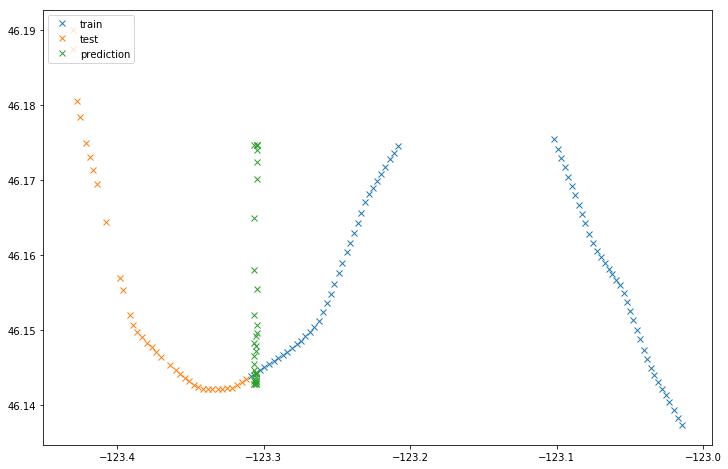

In [13]:
# Prediction and result

train_lat, test_lat, prediction_lat, baseline_lat, error_lat = rf_trajectory(gap_df, 0.67, 'LAT')
train_lon, test_lon, prediction_lon, baseline_lon, error_lon = rf_trajectory(gap_df, 0.67, 'LON')

plt.figure(figsize=(12,8))
plt.plot(np.asarray(train_lon['LON']), np.asarray(train_lat['LAT']), 'x', label = 'train')
plt.plot(np.asarray(test_lon['LON']), np.asarray(test_lat['LAT']), 'x', label = 'test')
plt.plot(np.asarray(prediction_lon), np.asarray(prediction_lat), 'x', label = 'prediction')
plt.legend(loc = 'upper left')

In [14]:
# compare for other trip

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def compare_pred(tripid):

    df = dynamic_data.loc[dynamic_data['TripID'] == tripid].sort_values('BaseDateTime')
    train_lat, test_lat, prediction_lat, baseline_lat, error_lat = rf_trajectory(df, 0.75, 'LAT')
    train_lon, test_lon, prediction_lon, baseline_lon, error_lon = rf_trajectory(df, 0.75, 'LON')

    mean_baseline = (baseline_lat + baseline_lon)/2
    mean_rf = (error_lat + error_lon)/2
    print('Mean baseline: %.5f' % mean_baseline)
    print('Mean RF: %.5f' % mean_rf)

    plt.figure(figsize=(12,8))
    plt.plot(np.asarray(train_lon['LON']), np.asarray(train_lat['LAT']), 'x', label = 'train')
    plt.plot(np.asarray(test_lon['LON']), np.asarray(test_lat['LAT']), 'x', label = 'test')
    plt.plot(np.asarray(prediction_lon), np.asarray(prediction_lat), 'x', label = 'prediction')
    plt.legend(loc = 'upper left')

    df = dynamic_data.loc[dynamic_data['TripID'] == tripid].sort_values('BaseDateTime')
    df = df.reset_index().drop(columns = ['index']) # reindex to be able to make actions on the index value
    index_start = df.index[int(0.25 * len(df))]
    index_end = df.index[int(0.50 * len(df))]

    gap_df = df.loc[df.index < index_start]
    gap_df = gap_df.append(df.loc[df.index > index_end])

    train_lat, test_lat, prediction_lat, baseline_lat, error_lat = rf_trajectory(gap_df, 0.67, 'LAT')
    train_lon, test_lon, prediction_lon, baseline_lon, error_lon = rf_trajectory(gap_df, 0.67, 'LON')

    mean_baseline = (baseline_lat + baseline_lon)/2
    mean_rf = (error_lat + error_lon)/2
    print('Mean baseline: %.5f' % mean_baseline)
    print('Mean RF: %.5f' % mean_rf)

    plt.figure(figsize=(12,8))
    plt.plot(np.asarray(train_lon['LON']), np.asarray(train_lat['LAT']), 'x', label = 'train')
    plt.plot(np.asarray(test_lon['LON']), np.asarray(test_lat['LAT']), 'x', label = 'test')
    plt.plot(np.asarray(prediction_lon), np.asarray(prediction_lat), 'x', label = 'prediction')
    plt.legend(loc = 'upper left')
    
interact(compare_pred,
         tripid = widgets.BoundedIntText(value = 1,
                                         min = 1,
                                         max = 1520,
                                         step = 1,
                                         description = 'TripID [1 ; 1520]:',
                                         disabled = False,))

interactive(children=(BoundedIntText(value=1, description='TripID [1 ; 1520]:', max=1520, min=1), Output()), _…

<function __main__.compare_pred(tripid)>

## Incorrect data <a class="anchor" id="incorrect-data"></a>

Exercise of prediction with wrong data
+ wrong unit of measurement for, for example, length or width
+ try misusing latitude and longitude values, and get for example cities from it

Length and width seem to have only correct or missing values. No wrong unit of measurement, maybe artificially add it?
For misusing latitude and longitude, it doesn't seem like a very interesting task.

In [15]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

In [16]:
static_data['Length'].describe()

count    1220.000000
mean       56.769590
std        74.739358
min         6.710000
25%        14.840000
50%        22.340000
75%        41.277500
max       349.000000
Name: Length, dtype: float64

In [17]:
static_data['Width'].describe()

count    911.000000
mean      13.104501
std       10.903338
min        0.000000
25%        5.500000
50%        8.000000
75%       16.350000
max       50.000000
Name: Width, dtype: float64

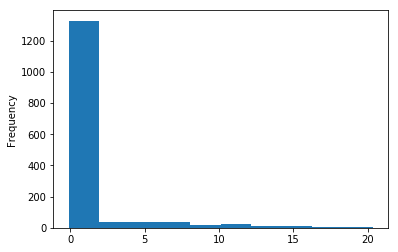

In [18]:
static_data['MeanSOG'].plot.hist()

In [19]:
import pandas as pd
import reverse_geocoder as rg

def reverseGeocode(lat, lon):
    
    coordinates = (lat, lon)
    result = rg.search(coordinates)
    
    # result[0] is an OrderedDict containing 'lat', 'lon', 'name', 'admin1', 'admin2', 'cc'
    return result[0]

print(static_data.loc[0, 'DepLat'])
print(static_data.loc[0, 'DepLon'])

geo = reverseGeocode(static_data.loc[0, 'DepLat'], static_data.loc[0, 'DepLon'])
print(geo['name'])
print(geo['cc'])

geo = reverseGeocode(static_data.loc[0, 'DepLon'], static_data.loc[0, 'DepLon'])
print(geo['name'])
print(geo['cc'])

geo = reverseGeocode(static_data.loc[0, 'DepLon'], static_data.loc[0, 'DepLat'])
print(geo['name'])
print(geo['cc'])

geo = reverseGeocode(static_data.loc[0, 'DepLat'], static_data.loc[0, 'DepLat'])
print(geo['name'])
print(geo['cc'])

48.51094000000001
-122.60705
Loading formatted geocoded file...
Anacortes
US
Punta Arenas
CL
Port-aux-Francais
TF
Shalkar
KZ


## Biased data <a class="anchor" id="biased-data"></a>

### 1
Exercise of prediction using immobile / mobile trips

In [20]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

1.2733923934326852


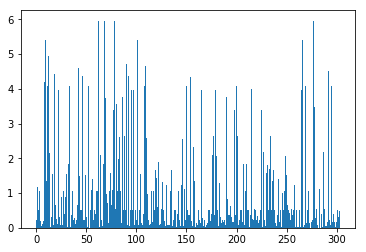

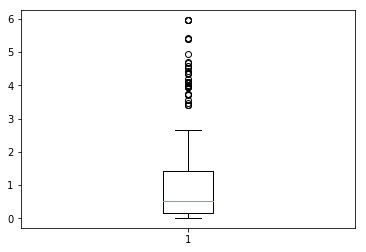

In [21]:
# Predict MeanSOG from all the data (including a lot of immobile ships)

from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

x = ['VesselType', 'Length', 'Width', 'Draft']
y = ['MeanSOG']

predictions, y_test = knn_regression(static_data, x, y)

pred = []
for element in predictions:
    pred.append(element[0])

print(mean_absolute_error(predictions, y_test))
plt.bar(np.arange(len(pred)), pred)
plt.show()

plt.boxplot(predictions)
plt.show()

2.8503720152323386


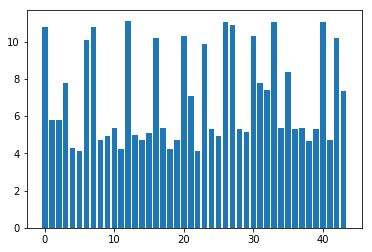

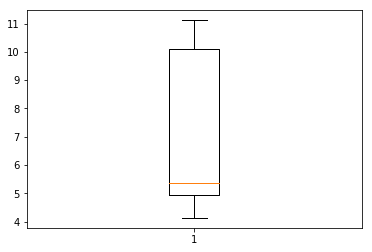

In [22]:
# Predict MeanSOG from only ships with MeanSOG > 1

from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

x = ['VesselType', 'Length', 'Width', 'Draft']
y = ['MeanSOG']

df = static_data.loc[static_data['MeanSOG'] >= 1]

predictions, y_test = knn_regression(df, x, y)

pred = []
for element in predictions:
    pred.append(element[0])

print(mean_absolute_error(predictions, y_test))
plt.bar(np.arange(len(pred)), pred)
plt.show()

plt.boxplot(predictions)
plt.show()

0.04326256486970714


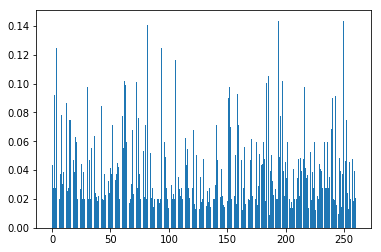

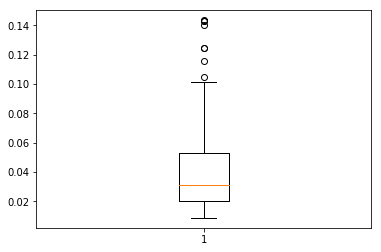

In [23]:
# Predict MeanSOG from only ships with MeanSOG < 1

from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

x = ['VesselType', 'Length', 'Width', 'Draft']
y = ['MeanSOG']

df = static_data.loc[static_data['MeanSOG'] < 1]

predictions, y_test = knn_regression(df, x, y)

pred = []
for element in predictions:
    pred.append(element[0])

print(mean_absolute_error(predictions, y_test))
plt.bar(np.arange(len(pred)), pred)
plt.show()

plt.boxplot(predictions)
plt.show()

### 2
Exercise of prediction with a lot of identical data vs. normal dataset (error in copy)

In [24]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

We choose a row without a lot of missing values.

In [25]:
static_data.head()

,TripID,MMSI,MeanSOG,VesselName,IMO,CallSign,VesselType,Length,Width,Draft,Cargo,DepTime,ArrTime,DepLat,DepLon,ArrLat,ArrLon,DepCountry,DepCity,ArrCountry,ArrCity,Duration
0,1,367114690,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:06,2017-01-01 02:40:45,48.51094,-122.60705,48.51095,-122.60705,US,Anacortes,US,Anacortes,0 days 02:40:39
1,2,367479990,6.536585,WSF KENNEWICK,IMO9618331,WDF6991,1012.0,83.39,19.5,3.2,NaN,2017-01-01 00:00:03,2017-01-01 02:40:44,48.15891,-122.67268,48.11099,-122.75885,US,Coupeville,US,Port Townsend,0 days 02:40:41
2,3,368319000,0.000758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:08,2017-01-01 02:44:48,43.34576,-124.32142,43.34578,-124.32141,US,Barview,US,Barview,0 days 02:44:40
3,4,367154100,6.871111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:15,2017-01-01 02:33:28,46.74264,-124.93125,47.02928,-124.95153,US,Ocean Shores,US,Ocean Shores,0 days 02:33:13
4,5,367446870,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:59,2017-01-01 02:42:54,48.51320,-122.60718,48.51318,-122.60699,US,Anacortes,US,Anacortes,0 days 02:41:55


We create a few different datasets by copying this row 10 times, 100 times, 1000 times, 10000 times, 100000 times.

In [26]:
%%time
line = static_data.loc[1]
df10 = static_data.append(line)
df10.name = 'df10'
for i in range(9):
    df10 = df10.append(line)

Wall time: 65 ms


In [27]:
%%time
line = static_data.loc[1]
df100 = df10.append(line)
df100.name = 'df100'
for i in range(89):
    df100 = df100.append(line)

Wall time: 442 ms


In [28]:
%%time
line = static_data.loc[1]
df1000 = df100.append(line)
df1000.name = 'df1000'
for i in range(889):
    df1000 = df1000.append(line)

Wall time: 4.98 s


In [29]:
%%time
line = static_data.loc[1]
df10000 = df1000.append(line)
df10000.name = 'df10000'
for i in range(8889):
    df10000 = df10000.append(line)

Wall time: 1min


In [30]:
static_data.describe()

,TripID,MMSI,MeanSOG,VesselType,Length,Width,Draft,Cargo,DepLat,DepLon,ArrLat,ArrLon
count,1520.000000,1.520000e+03,1520.000000,1287.000000,1220.000000,911.000000,496.000000,378.000000,1520.000000,1520.000000,1520.000000,1520.000000
mean,760.500000,3.597421e+08,1.034825,971.680653,56.769590,13.104501,6.457056,50.515873,46.354331,-122.868905,46.353671,-122.871346
std,438.930518,6.263661e+07,2.936439,198.957887,74.739358,10.903338,4.607529,22.693810,3.766705,0.681947,3.762056,0.680604
min,1.000000,3.160089e+06,-0.100000,0.000000,6.710000,0.000000,0.000000,0.000000,32.220640,-125.995610,32.209370,-125.998590
25%,380.750000,3.380724e+08,0.000000,1004.000000,14.840000,5.500000,3.000000,31.000000,46.168652,-123.178480,46.168460,-123.168262
50%,760.500000,3.669802e+08,0.012633,1019.000000,22.340000,8.000000,4.650000,52.000000,47.647795,-122.651365,47.646925,-122.645290
75%,1140.250000,3.675663e+08,0.072000,1019.000000,41.277500,16.350000,10.025000,70.000000,48.656940,-122.386562,48.665710,-122.386607
max,1520.000000,9.876543e+08,20.360811,1025.000000,349.000000,50.000000,18.800000,99.000000,49.890740,-120.002920,49.832120,-120.002420


In [31]:
for df in [df10, df100, df1000, df10000]:
    print(df.describe())

            TripID          MMSI      MeanSOG   VesselType       Length  \
count  1530.000000  1.530000e+03  1530.000000  1297.000000  1230.000000   
mean    755.542484  3.597927e+08     1.070784   971.991519    56.986016   
std     441.744387  6.243456e+07     2.960229   198.220215    74.473078   
min       1.000000  3.160089e+06    -0.100000     0.000000     6.710000   
25%     373.250000  3.380754e+08     0.000000  1004.000000    14.910000   
50%     755.500000  3.669823e+08     0.013043  1019.000000    22.620000   
75%    1137.750000  3.675648e+08     0.075694  1019.000000    43.715000   
max    1520.000000  9.876543e+08    20.360811  1025.000000   349.000000   

            Width       Draft       Cargo       DepLat       DepLon  \
count  921.000000  506.000000  378.000000  1530.000000  1530.000000   
mean    13.173941    6.392688   50.515873    46.366126  -122.867623   
std     10.864177    4.584196   22.693810     3.757184     0.679897   
min      0.000000    0.000000    0.00000

df: MAE = 1.2733923934326852
df10: MAE = 1.157407804442135
df100: MAE = 1.23786706177166
df1000: MAE = 0.9026804630340876
df10000: MAE = 0.20197894745555736


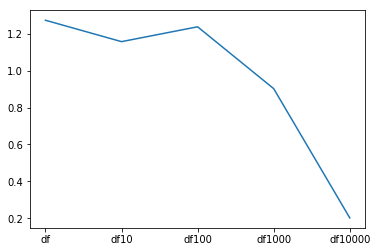

In [34]:
# Comparison of prediction of MeanSOG with normal static data and copied datasets

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

x = ['VesselType', 'Length', 'Width', 'Draft']
y = ['MeanSOG']

errors = [[], []]

static_data.name = 'df'
df10.name = 'df10'
df100.name = 'df100'
df1000.name = 'df1000'
df10000.name = 'df10000'

for df in [static_data, df10, df100, df1000, df10000]:
    predictions, y_test = knn_regression(df, x, y)
    error = mean_absolute_error(predictions, y_test)
    print(df.name + ': MAE = ' + str(error))
    
    errors[0].append(df.name)
    errors[1].append(error)
    
plt.plot(errors[0], errors[1])

## More ideas <a class="anchor" id="more-ideas"></a>

+ Try to predict with something that does not make sense (example: using ID attribute as a number)
+ or using Length as a category
+ mixing regression and classification

In [35]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

In [36]:
# Prediction of Width from Length or TripID

from sklearn.metrics import mean_absolute_error

x = ['Length']
y = ['Width']
pred, ytest = knn_regression(static_data, x, y)
print('MAE with Length: ' + str(mean_absolute_error(pred, ytest)))

x = ['Length', 'TripID']
y = ['Width']
pred, ytest = knn_regression(static_data, x, y)
print('MAE with Length and TripID: ' + str(mean_absolute_error(pred, ytest)))

x = ['TripID']
y = ['Width']
pred, ytest = knn_regression(static_data, x, y)
print('MAE with TripID: ' + str(mean_absolute_error(pred, ytest)))

print('Baseline: mean = ' + str(static_data['Width'].mean()))

MAE with Length: 2.73451052631579
MAE with Length and TripID: 3.8834960526315796
MAE with TripID: 7.796980263157895
Baseline: mean = 13.10450054884743


In [37]:
# Prediction of Width from Length: comparison regression and classification

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

x = ['Length']
y = ['Width']

df = static_data.copy()
df = df.dropna()

pred, ytest = knn_regression(df, x, y)

print('MAE with regression: ' + str(mean_absolute_error(pred, ytest)))

df2 = static_data.copy()
df2 = df2.dropna()
df2['Width'] = df2['Width'].astype('int')
df2['Width'] = df2['Width'].astype('category')

pred, ytest = knn_classification(df2, x, y)

print('Accuracy with classification: ' + str(accuracy_score(pred, ytest)))

MAE with regression: 2.0717238095238097
Accuracy with classification: 0.38095238095238093


C:\Users\Anna\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
